In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/retail_raw_reduced.csv')

In [3]:
dataset['order_month'] = dataset['order_date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime('%Y-%m'))

In [4]:
dataset['gmv'] = dataset['item_price'] * dataset['quantity']

(0.0, 41.05)

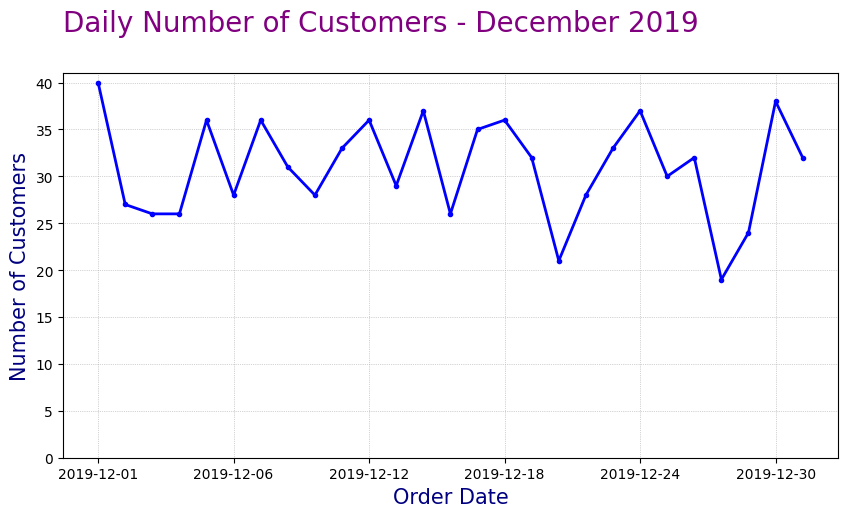

In [5]:
plt.figure(figsize=(10, 5))
dataset[dataset['order_month']=='2019-12'].groupby(['order_date'])['customer_id'].nunique().plot(color='blue', marker='.', linewidth=2)
plt.title('Daily Number of Customers - December 2019', loc='left', pad=30, fontsize=20, color='purple')
plt.xlabel('Order Date', fontsize=15, color='navy')
plt.ylabel('Number of Customers', fontsize=15, color='navy')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
plt.ylim(ymin=0)

Case 1 (Menentukan Brand Top 5)

In [6]:
#mengambil informasi top 5 brands berdasarkan quantity
top_brands = (dataset[dataset['order_month']=='2019-12'].groupby('brand')['quantity']
                .sum()
                .reset_index()
                .sort_values(by='quantity',ascending=False)
                .head(5))
#membuat dataframe baru, filter hanya di bulan Desember 2019 dan hanya top 5 brands
dataset_top5brand_dec = dataset[(dataset['order_month']=='2019-12') & (dataset['brand'].isin(top_brands['brand'].to_list()))]
# print top brands
print(top_brands)

     brand  quantity
8  BRAND_S      2197
6  BRAND_P      2194
7  BRAND_R      1508
2  BRAND_C      1365
0  BRAND_A      1315


Case 2 Multi-line chart daily quantity untuk brand top 5

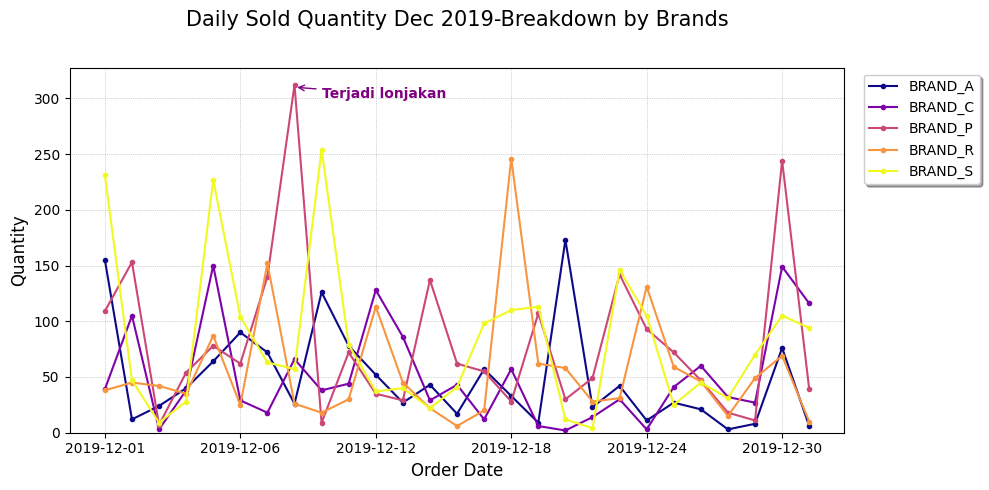

In [7]:
dataset_top5brand_dec.groupby(['order_date','brand'])['quantity'].sum().unstack().plot(marker='.', cmap='plasma')
plt.title('Daily Sold Quantity Dec 2019-Breakdown by Brands',loc='center',pad=30, fontsize=15, color='black')
plt.xlabel('Order Date', fontsize = 12)
plt.ylabel('Quantity',fontsize = 12)
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
plt.ylim(ymin=0)
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1), shadow=True, ncol=1)
plt.annotate('Terjadi lonjakan', xy=(7, 310), xytext=(8, 300),
             weight='bold', color='purple',
             arrowprops=dict(arrowstyle='->',
                             connectionstyle="arc3",
                             color='purple'))
plt.gcf().set_size_inches(10, 5)
plt.tight_layout()

Case 3 menentukan jumlah product untuk masing-masing brand yang laku selama bulan Desember 2019

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'BRAND_S'),
  Text(1, 0, 'BRAND_P'),
  Text(2, 0, 'BRAND_R'),
  Text(3, 0, 'BRAND_C'),
  Text(4, 0, 'BRAND_A')])

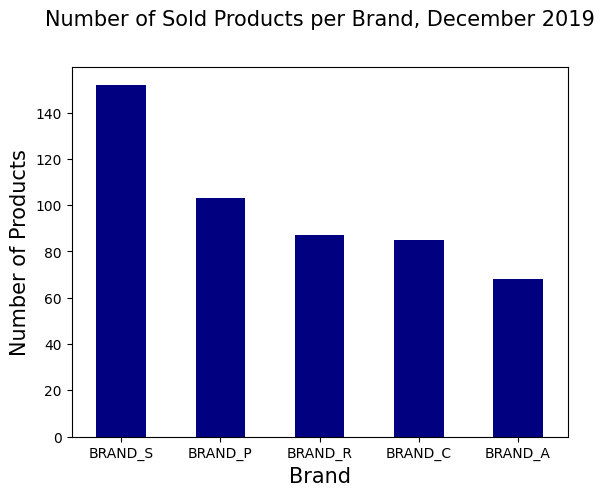

In [8]:
plt.clf()
dataset_top5brand_dec.groupby('brand')['product_id'].nunique().sort_values(ascending=False).plot(kind='bar', color='navy')
plt.title('Number of Sold Products per Brand, December 2019',loc='center',pad=30, fontsize=15, color='black')
plt.xlabel('Brand', fontsize = 15)
plt.ylabel('Number of Products',fontsize = 15)
plt.ylim(ymin=0)
plt.xticks(rotation=0)

Case 4 Penjualan produk diatas 100 dan dibawah 100 selama Desember 2019
Gunakan stacked chart

Membuat dataframe baru, untuk agregat jumlah quantity terjual per product

In [9]:
dataset_top5brand_dec_per_product = dataset_top5brand_dec.groupby(['brand','product_id'])['quantity'].sum().reset_index()

beri kolom baru untuk menandai product yang terjual >= 100 dan <100

In [10]:
dataset_top5brand_dec_per_product['quantity_group'] = dataset_top5brand_dec_per_product['quantity'].apply(lambda x: '>= 100' if x>=100 else '< 100')
dataset_top5brand_dec_per_product.sort_values('quantity',ascending=False,inplace=True)

membuat referensi pengurutan brand berdasarkan banyaknya semua product

In [11]:
s_sort = dataset_top5brand_dec_per_product.groupby('brand')['product_id'].nunique().sort_values(ascending=False)

plot stacked barchart

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'BRAND_S'),
  Text(1, 0, 'BRAND_P'),
  Text(2, 0, 'BRAND_R'),
  Text(3, 0, 'BRAND_C'),
  Text(4, 0, 'BRAND_A')])

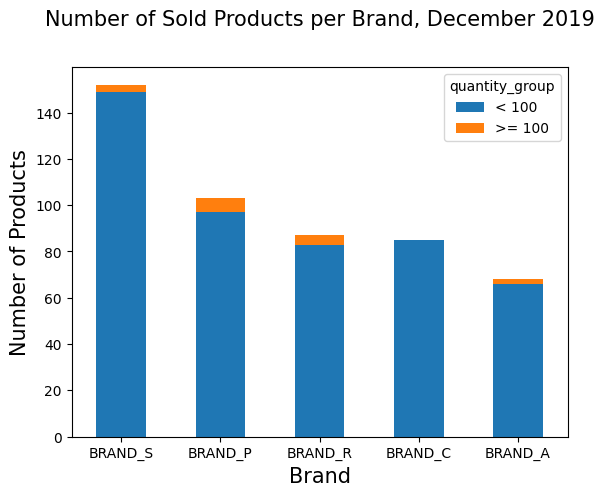

In [12]:
dataset_top5brand_dec_per_product.groupby(['brand','quantity_group'])['product_id'].nunique().reindex(index=s_sort.index, level='brand').unstack().plot(kind='bar', stacked=True)
plt.title('Number of Sold Products per Brand, December 2019',loc='center',pad=30, fontsize=15, color='black')
plt.xlabel('Brand', fontsize = 15)
plt.ylabel('Number of Products',fontsize = 15)
plt.ylim(ymin=0)
plt.xticks(rotation=0)

Case 5 Gunakan histogram untuk melihat distribusi harga product-product yang ada di top 5 brand

(0.0, 2000000.0)

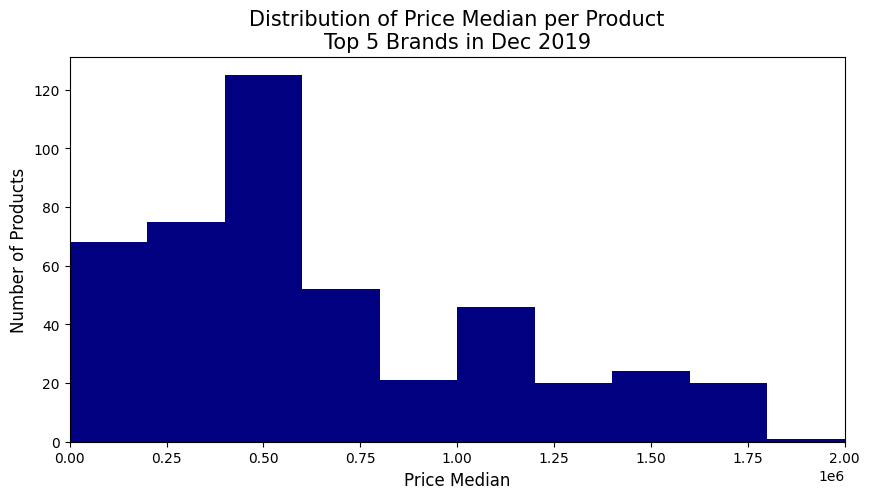

In [13]:
plt.figure(figsize=(10,5))
plt.hist(dataset_top5brand_dec.groupby('product_id')['item_price'].median(), bins=10, stacked=True, range=(1,2000000), color='navy')
plt.title('Distribution of Price Median per Product\nTop 5 Brands in Dec 2019',fontsize=15, color='black')
plt.xlabel('Price Median', fontsize = 12)
plt.ylabel('Number of Products',fontsize = 12)
plt.xlim(xmin=0,xmax=2000000)

Case 6A Korelasi quantity vs GMV

([<matplotlib.axis.YTick at 0x7fb31d5305e0>,
 [Text(0, 0.0, '0'),
  Text(0, 25000000.0, '25'),
  Text(0, 50000000.0, '50'),
  Text(0, 75000000.0, '75'),
  Text(0, 100000000.0, '100'),
  Text(0, 125000000.0, '125'),
  Text(0, 150000000.0, '150'),
  Text(0, 175000000.0, '175'),
  Text(0, 200000000.0, '200')])

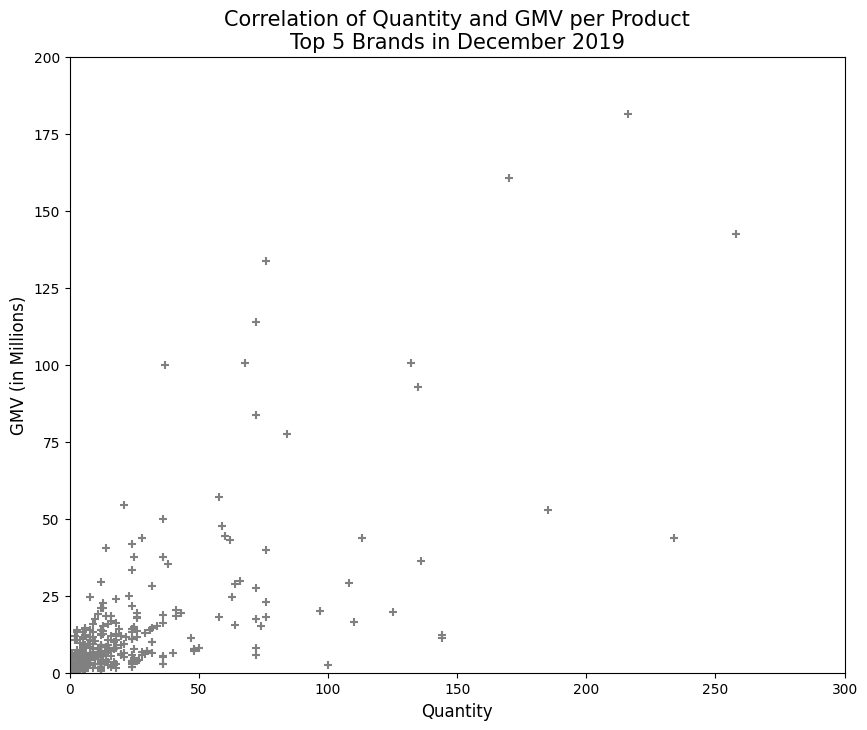

In [14]:
#agregat per product
data_per_product_top5brand_dec = dataset_top5brand_dec.groupby('product_id').agg({'quantity': 'sum', 'gmv':'sum', 'item_price':'median'}).reset_index()
#scatter plot
plt.figure(figsize=(10,8))
plt.scatter(data_per_product_top5brand_dec['quantity'],data_per_product_top5brand_dec['gmv'], marker='+', color='grey')
plt.title('Correlation of Quantity and GMV per Product\nTop 5 Brands in December 2019',fontsize=15, color='black')
plt.xlabel('Quantity', fontsize = 12)
plt.ylabel('GMV (in Millions)',fontsize = 12)
plt.xlim(xmin=0,xmax=300)
plt.ylim(ymin=0,ymax=200000000)
labels, locations = plt.yticks()
plt.yticks(labels, (labels/1000000).astype(int))

Case 6B  Korelasi median harga vs quantity

(0.0, 250.0)

<Figure size 640x480 with 0 Axes>

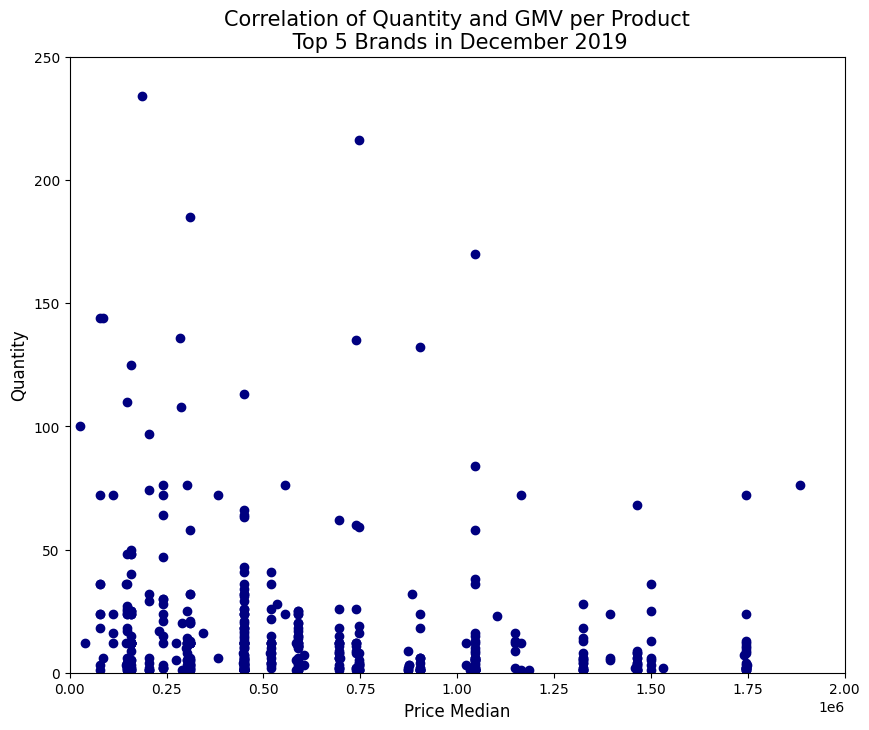

In [15]:
import matplotlib.pyplot as plt
plt.clf()
#agregat per product
data_per_product_top5brand_dec = dataset_top5brand_dec.groupby('product_id').agg({'quantity': 'sum', 'gmv':'sum', 'item_price':'median'}).reset_index()
#scatter plot
plt.figure(figsize=(10,8))
plt.scatter(data_per_product_top5brand_dec['item_price'],data_per_product_top5brand_dec['quantity'], marker='o', color='navy')
plt.title('Correlation of Quantity and GMV per Product\n Top 5 Brands in December 2019',fontsize=15, color='black')
plt.xlabel('Price Median', fontsize = 12)
plt.ylabel('Quantity',fontsize = 12)
plt.xlim(xmin=0,xmax=2000000)
plt.ylim(ymin=0,ymax=250)